In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

from aux import loadmat_h5
from disp import set_font_size

TUNING_FILE = 'data/simple/ipi_freq_timecourses.npy'
CELL_FILE = 'data/christa/VLP_knownAUD_neurons_copiedFromFlyWireDatabase_20200617.xlsx'
# W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn.mat'
W_FILE = 'data/christa/allAudNeurons_connMat_noDupSyn_cleftFilt_20210603.mat'

FPS = 8.5

In [2]:
tuning_data = np.load(TUNING_FILE, allow_pickle=True)[0]

ipi = tuning_data['ipi']
ipi_rsps = tuning_data['ipi_rsps_means']

freq = tuning_data['freq']
freq_rsps = tuning_data['freq_rsps_means']

In [3]:
cell_df = pd.read_excel(CELL_FILE, engine='openpyxl')
cell_df[['short name', 'lineID for IPI/Freq tuning curves', 'Eckstein NT classification numeric']]

,short name,lineID for IPI/Freq tuning curves,Eckstein NT classification numeric
0,A1_L1,NaN,NaN
1,A1_L2,NaN,NaN
2,A1_L3,NaN,NaN
3,A1_R1,NaN,NaN
4,A1_R2,NaN,NaN
...,...,...,...
493,pC1as_R1,NaN,1.0
494,pC1as_R2,NaN,1.0
495,NaN,NaN,NaN
496,NaN,NaN,NaN


In [4]:
labels = np.array(cell_df['short name'])
line_ids = np.array(cell_df['lineID for IPI/Freq tuning curves'])  # floats/ints from 1 to 30 inclusive
signs = np.array(cell_df['Eckstein NT classification numeric'])

label2line = {label: line_id for label, line_id in zip(labels, line_ids)}
label2sign = {label: np.sign(sign) for label, sign in zip(labels, signs)}

In [5]:
w_th = 1

w_data = loadmat_h5(W_FILE)
labels_w = w_data['neuronNames'][:, 0]  # all labels with a row in the connectivity matrix

w_raw = w_data['cxns_noDup']
w = w_raw.copy()
w[w_raw < w_th] = 0
w[np.isnan(w)] = 0

# add sign
sign_mat = np.zeros(w.shape)  # note this zeroes any weights without signs attached
for cl, label in enumerate(labels_w):
    if label in label2sign and not np.isnan(label2sign[label]):
        sign_mat[cl, :] = label2sign[label]
            
w = w*sign_mat  # multiply w by signs

In [6]:
for label in labels_w:  # fill any missing labels with nan
    if label not in label2line:
        label2line[label] = np.nan

How to get tuning curves idx associated w/ row i in w:

1. Get i'th label from label_w.
2. Look up line in label2line. I.e. line = label2line[label_w[i]].

In [7]:
def get_ipi_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = ipi_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(ipi), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No ipi responses for cell {label}')
        return None

def get_freq_timecourses(label, verbose=False): # get idx
    line = label2line[label]
    if not np.isnan(line): 
        rsp = freq_rsps[int(line - 1)]
        if rsp.shape[1] == 163:
            return np.concatenate([rsp, np.nan*np.zeros((len(freq), 1))], axis=1)  # make sure there are 164 timesteps in response array
        else:
            return rsp
    else:
        if verbose:  print(f'No freq responses for cell {label}')
        return None

In [8]:
# def w2rgba(w_, w_min=-1, w_max=1):
#     cmap = cm.get_cmap('PiYG')
#     return cmap(w_/6 + .5)

def w2rgba(w_, w_min=-3, w_max=3):
    if w_ < 0:
        r = np.min([w_/w_min, 1])
    else:
        r = 0
    if w_ > 0:
        g = np.min([w_/w_max, 1])
    else:
        g = 0
    b = 0
    a = 1
    return np.array([r, g, b, a])

Model emergence of tuning curve from upstream tuning via linear dynamical system

$$\tau \frac{dr_i}{dt} = -r_i + \sum_j W_{ij} r_j$$

Each target neuron (col in weight matrix) w/ corresponding tuning curve dataset gives distinct analysis to do. We take the tuning curve data for the target neuron, look up its upstream neighbors and their weights onto the target neuron, compute a model response using a linear dynamical system and the upstream responses, then recompute the tuning curve for the model responses.

In [9]:
# neurons to show
INRNS = [314, 306, 55, 135, 300, 151, 158, 299, 273, 343, 232, 426, 346, 270, 276, 296, 275, 278, 422, 277, 275, 313, 366, 254, 304, 407]
INRNS = [314, 306, 55, 135]

In [10]:
for inrn, label_w in enumerate(labels_w):
    if ('38918' in label_w) or ('27885' in label_w) or ('16374' in label_w):
        print(label_w, inrn)
        INRNS.append(inrn)

16374-27885_L1 178
16374-27885_L2 179
16374-27885_L3 180
16374-27885_L4 181
16374-27885_L5 182
16374-27885_L6 183
16374-27885_L7 184
16374-27885_Lb1 185
16374-27885_Lb2 186
16374-27885_R1 187
16374-27885_R2 188
16374-27885_R3 189
16374-27885_R4 190
16374-27885_R5 191
16374-27885_R6 192
16374-27885_R7 193
16374-27885_R8 194
16374-27885_Rb1 195
16374-27885_Rb2 196
27885_Lcom1 197
27885_Lcom2 198
27885_Lcom3 199
27885_Rcom1 200
27885_Rcom2 201
27885_Rcom3 202
38918_L 405
38918_R 406


314: 35996_R4, Presynaptic IPI responses (15 total, 2 missing)
306: 29146_R4, Presynaptic IPI responses (31 total, 14 missing)
No IPI tuning data for cell B1-4_R6
135: WED-VLP-1_L4, Presynaptic IPI responses (29 total, 3 missing)
178: 16374-27885_L1, Presynaptic IPI responses (21 total, 2 missing)
179: 16374-27885_L2, Presynaptic IPI responses (20 total, 1 missing)
180: 16374-27885_L3, Presynaptic IPI responses (21 total, 4 missing)
181: 16374-27885_L4, Presynaptic IPI responses (27 total, 0 missing)
182: 16374-27885_L5, Presynaptic IPI responses (34 total, 4 missing)
183: 16374-27885_L6, Presynaptic IPI responses (30 total, 3 missing)
184: 16374-27885_L7, Presynaptic IPI responses (27 total, 1 missing)
185: 16374-27885_Lb1, Presynaptic IPI responses (29 total, 3 missing)
186: 16374-27885_Lb2, Presynaptic IPI responses (21 total, 0 missing)
187: 16374-27885_R1, Presynaptic IPI responses (20 total, 1 missing)
188: 16374-27885_R2, Presynaptic IPI responses (26 total, 3 missing)
189: 1637

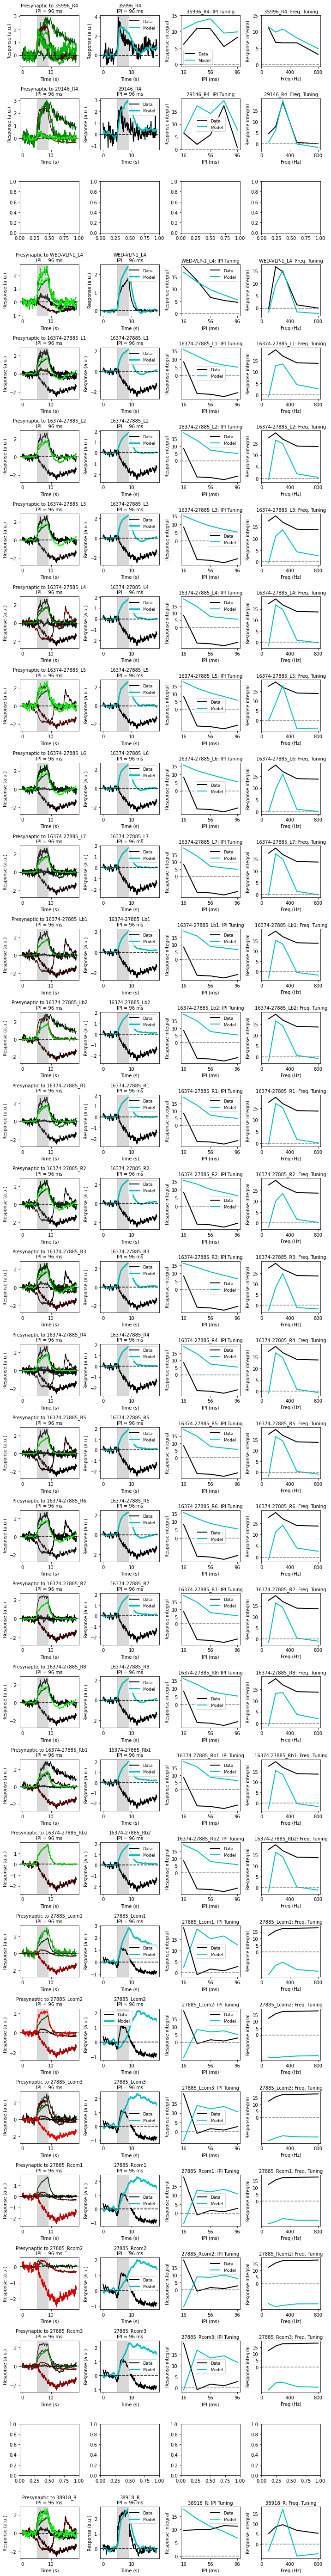

In [11]:
# IPI tuning
DT = 1/FPS
TAU = .5

fig, axs_all = plt.subplots(len(INRNS), 4, figsize=(10, 2.5*len(INRNS)), tight_layout=True)

for inrn, axs in zip(INRNS, axs_all):
    
    label = labels_w[inrn]
    
    t = np.arange(164)/FPS

    if np.isnan(label2line[label]):
        print(f'No IPI tuning data for cell {label}')
        continue
        
    # upstream inputs
    iup = w[:, inrn].nonzero()[0]  # idxs relative to w and labels_w
    w_up = w[iup, inrn]  # weights
    labels_up = labels_w[iup]  # labels
    lines_up = np.array([label2line[label_up] for label_up in labels_up])
    
    # subset of upstream inputs with tuning curve data (mask for previous 4 arrays)
    mvalid = ~np.isnan(lines_up)
    assert len(iup) == len(w_up) == len(labels_up) == len(lines_up)
    
    if np.sum(mvalid) == 0:
        print(f'No upstream IPI tuning data for cell {label}')
        continue
 
    labels_up_valid = labels_up[mvalid]  # labels of upstream cells w/ IPI data
    labels_up_missing = labels_up[~mvalid]  # labels of upstream cells w/o IPI data
 
    # weights corresponding to valid upstream labels
    w_up_valid = w_up[mvalid]
    w_scale = np.nanstd(w_up_valid) if len(w_up_valid) >= 2 else 1
    w_up_valid /= w_scale
    
    # target neuron's true ipi time courses
    rsps_data = get_ipi_timecourses(label)
    rsps_data /= np.nanstd(rsps_data)  # z-score across time & stims

    # upstream neuron ipi time courses
    rsps_up_all = [get_ipi_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each IPI
    rsps_model = np.nan * np.zeros((len(ipi), len(t)))  # one row per IPI
    for cipi, ipi_ in enumerate(ipi):
        # get array of upstream neuron activities for this IPI
        rsp_up = np.array([rsps_up[cipi, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        r[0] = 0

        for ct, t_ in enumerate(t[1:], 1):
            dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
            r[ct] = r[ct-1] + dr
        
        rsps_model[cipi, :] = r.copy()
        
    rsps_model /= np.nanstd(rsps_model)  # z-score across time & stims
    
    # compute IPI tuning curves for data and model
    mtuning = (5 <= t) & (t < 13)
    
    rsp_tavg_data = np.array([rsp_data[mtuning].sum()*DT for rsp_data in rsps_data])
    rsp_tavg_model = np.array([rsp_model[mtuning].sum()*DT for rsp_model in rsps_model])
    
    iipi_plot = 2  # index of IPI to plot response for
    # plot all upstream responses (i.e. inputs) colored by weight
    rsp_up = np.array([rsps_up[iipi_plot, :] for rsps_up in rsps_up_all])  # upstream responses at this IPI
    assert len(rsp_up) == len(w_up_valid)

    for rsp_up_, w_ in zip(rsp_up, w_up_valid):
        axs[0].plot(t, rsp_up_, c=w2rgba(w_), zorder=int(round(np.abs(w_))))

    axs[0].axhline(0, color='k', ls='--')
    axs[0].axvspan(5, 9, color='gray', alpha=.3)
    
    print(f'{inrn}: {label}, Presynaptic IPI responses ({len(w_up)} total, {len(labels_up_missing)} missing)')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Response (a.u.)')
    axs[0].set_title(f'Presynaptic to {label}\nIPI = {ipi_} ms')
        
    # true vs modeled target neuron response (for all IPIs)
    axs[1].plot(t, rsps_data[iipi_plot], c='k', lw=2)
    axs[1].plot(t, rsps_model[iipi_plot], c='c', lw=3)
    axs[1].axvspan(5, 9, color='gray', alpha=.3)
    axs[1].axhline(0, color='k', ls='--')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Response (a.u.)')
    axs[1].set_title(f'{label}\nIPI = {ipi_} ms')

    axs[1].legend(['Data', 'Model'])

    axs[2].plot(ipi, rsp_tavg_data, c='k', lw=2)
    axs[2].plot(ipi, rsp_tavg_model, c='c', lw=2)
    axs[2].axhline(0, color='gray', ls='--')
    axs[2].set_xticks([16, 56, 96])
    axs[2].set_yticks([0, 5, 10, 15])
    axs[2].set_xlabel('IPI (ms)')
    axs[2].set_ylabel('Response integral')
    axs[2].set_title(f'{label}: IPI Tuning')
    axs[2].legend(['Data', 'Model'])

    # target neuron's true freq time courses
    rsps_data = get_freq_timecourses(label)
    rsps_data /= np.nanstd(rsps_data)  # z-score across time & stims

    # upstream neuron freq time courses
    rsps_up_all = [get_freq_timecourses(label_up) for label_up in labels_up_valid]
    
    # run simulation for each FREQ
    rsps_model = np.nan * np.zeros((len(freq), len(t)))  # one row per FREQ
    for cfreq, freq_ in enumerate(freq):
        # get array of upstream neuron activities for this FREQ
        rsp_up = np.array([rsps_up[cfreq, :] for rsps_up in rsps_up_all])
        assert rsp_up.shape == (len(labels_up_valid), len(t)) or len(rsp_up) == 0
        
        r = np.nan * np.zeros(len(t))
        
        r[0] = 0

        for ct, t_ in enumerate(t[1:], 1):
            dr = (DT/TAU) * (-r[ct-1] + w_up_valid@rsp_up[:, ct])
            r[ct] = r[ct-1] + dr
        
        rsps_model[cfreq, :] = r.copy()
        
    rsps_model /= np.nanstd(rsps_model)  # z-score across time & stims
    
    # compute freq tuning curves for data and model
    mtuning = (5 <= t) & (t < 13)
    
    rsp_tavg_data = np.array([rsp_data[mtuning].sum()*DT for rsp_data in rsps_data])
    rsp_tavg_model = np.array([rsp_model[mtuning].sum()*DT for rsp_model in rsps_model])

    axs[3].plot(freq, rsp_tavg_data, c='k', lw=2)
    axs[3].plot(freq, rsp_tavg_model, c='c', lw=2)
    axs[3].axhline(0, color='gray', ls='--')
    axs[3].set_xticks([0, 400, 800])
    axs[3].set_yticks([0, 5, 10, 15])
    axs[3].set_xlabel('Freq (Hz)')
    axs[3].set_ylabel('Response integral')
    axs[3].set_title(f'{label}: Freq. Tuning')
    
    set_font_size(axs, 10, legend_font_size=9)

In [12]:
fig.savefig(f'plots/cb_ms/tuning_model_examples_many.png', dpi=150)